<a href="https://www.kaggle.com/code/peremartramanonellas/gan-tutorial-2-generating-color-images?scriptVersionId=122017012" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    horizontal-align: middle;
}
h1 {
    text-align: center;
    background-color: AliceBlue;
    padding: 10px;
    margin: 0;
    font-family: monospace;
    color:DimGray;
    border-radius: 10px
}

h2 {
    text-align: center;
    background-color: HoneyDew;
    padding: 10px;
    margin: 0;
    font-family: monospace;
    color:DimGray;
    border-radius: 10px
}

h3 {
    text-align: center;
    background-color: MintCream;
    padding: 10px;
    margin: 0;
    font-family: monospace;
    color:DimGray;
    border-radius: 10px
}


body, p {
    font-family: monospace;
    font-size: 15px;
    color: charcoal;
}
div {
    font-size: 14px;
    margin: 0;

}

h4 {
    padding: 0px;
    margin: 0;
    font-family: monospace;
    color: purple;
}
</style>
""")

# Creating a GAN to generate Small Color Images
We are going to work wth the Dataset Cifar10. 

This is the second notebook dedicated to GANs, we will continue exploring how to do the uopsizing to transform the input noise of the generator in a image with the correct shape. 

In our first notebook: 
https://www.kaggle.com/code/peremartramanonellas/gan-tutorial-first-dcgan-using-tensorflow
We were working with small images in a gray scale. In thgis one the images are slightly larger, and with color. 

Now we have a 32 x 32 x 3 shape instead of 28 x 28 x 1. 

As it is not a big change, I take the opportunity to introduce a new optimization of the GAN Hack: label smoothing.

In the last part of the notebook, we will create two functions that allow us to build different generators and discriminators. We will create different models and compare the result.

You have more explanations in an article published in Medium: 
https://medium.com/towards-artificial-intelligence/how-to-make-a-gan-to-generate-color-images-33d29f8a79c8


## Libraries, Dataset & Support functions.¶


In [2]:
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

from keras.utils.vis_utils import plot_model

print (tf.__version__)

2.9.2


In [3]:
def plot_results(images, n_cols=None, unnorm=True):
    '''visualizes fake images'''
    display.clear_output(wait=False)  

    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(n_cols, n_rows))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        imageorg = image
        if unnorm:
          imageorg = (image +1) * 0.5
        plt.imshow(imageorg)
        plt.axis("off")

In [4]:
# download the training images from keras
(X_train, _), _ = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


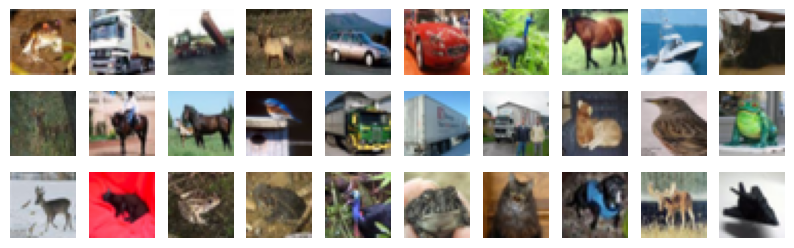

In [5]:
plot_results(X_train[0:30], 10, False)

In [6]:
# The GAN Hacks recommend to normalize and scale the pixals to values between -1 and 1. 
# normalize pixel values
X_train = X_train.astype(np.float32)

#Rescale
X_train = (X_train -127.5) / 127.5

BATCH_SIZE = 128

# create batches of tensors to be fed into the model
dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

In [7]:
#Pixel values in on of the images. 
X_train[1]

array([[[ 0.20784314,  0.3882353 ,  0.46666667],
        [-0.01176471,  0.07450981,  0.06666667],
        [-0.1764706 , -0.18431373, -0.25490198],
        ...,
        [-0.28627452, -0.25490198, -0.44313726],
        [-0.31764707, -0.29411766, -0.44313726],
        [-0.38039216, -0.3647059 , -0.4509804 ]],

       [[ 0.09803922,  0.25490198,  0.3254902 ],
        [ 0.13725491,  0.2       ,  0.20784314],
        [-0.01960784, -0.01960784, -0.07450981],
        ...,
        [-0.24705882, -0.22352941, -0.3882353 ],
        [-0.39607844, -0.37254903, -0.5137255 ],
        [-0.44313726, -0.42745098, -0.52156866]],

       [[ 0.09803922,  0.21568628,  0.28627452],
        [ 0.09019608,  0.14509805,  0.16862746],
        [-0.09803922, -0.09803922, -0.12156863],
        ...,
        [-0.38039216, -0.35686275, -0.49803922],
        [-0.46666667, -0.4509804 , -0.5686275 ],
        [-0.4745098 , -0.45882353, -0.5686275 ]],

       ...,

       [[ 0.37254903,  0.30980393,  0.3019608 ],
        [ 0

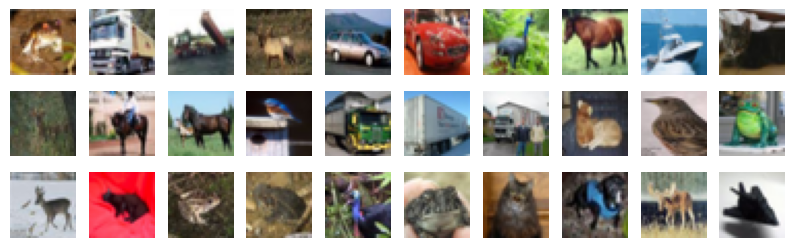

In [8]:
plot_results(X_train[0:30], 10)

## The Generator model of the GAN
The Generator model should output a 32 x 32 x 3 image.

As input, it will receive noise, a vector of random data that follows a Gaussian distribution.

It will transform this input into fake images to send to the discriminator.

Mainly, it will perform two actions to get the output image. Learn to modify the data in order to create images that deceive the discriminator, and to upsize the data to reach its desired size.

In [9]:
noise_input = 100
generator = keras.models.Sequential([
    keras.layers.Dense(4 * 4 * 128, input_shape=[noise_input], 
                       activation=keras.layers.LeakyReLU(alpha=0.2)),
    
    #Start with small representations of the image of 4 x 4
    keras.layers.Reshape([4, 4, 128]),
    keras.layers.BatchNormalization(),

    #First UpSample doubling the size to 8x8
    keras.layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="SAME", 
                                 activation=keras.layers.LeakyReLU(alpha=0.2)),
    keras.layers.BatchNormalization(),

    #Second UpSample doubling the size to 16x16
    keras.layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="SAME", 
                                 activation=keras.layers.LeakyReLU(alpha=0.2)),
    keras.layers.BatchNormalization(),

    #Last UpSample doubling the size to 32x32
    keras.layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding="SAME",
                                 activation='tanh'),
                                 ])

In [10]:
#From noise to 32 x 32 x 3
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              206848    
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 128)        512       
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        262272    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        512       
 hNormalization)                                                 
                                                        

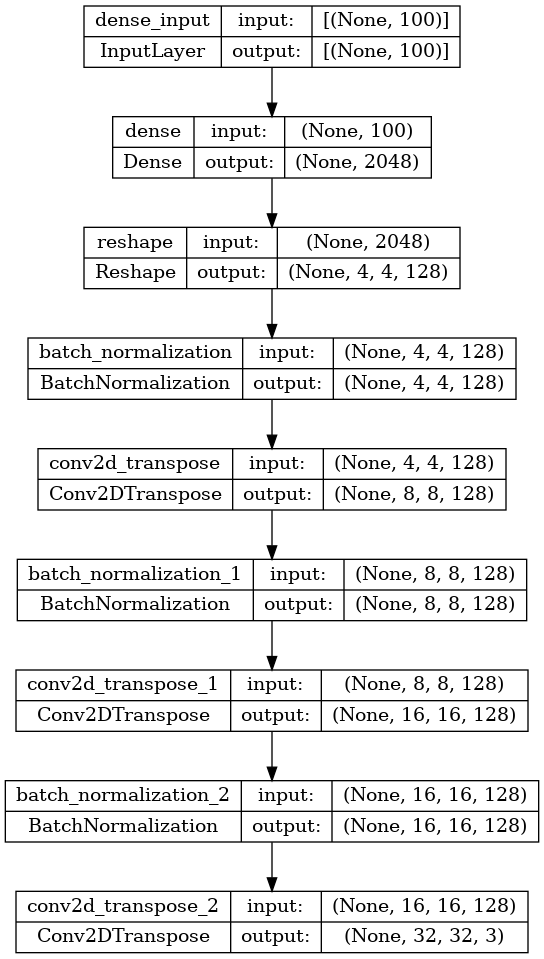

In [11]:
#From noise to 32 x 32 x 3
plot_model(generator, show_shapes=True, 
           show_layer_names=True)

shape of the generated batch: (16, 32, 32, 3)


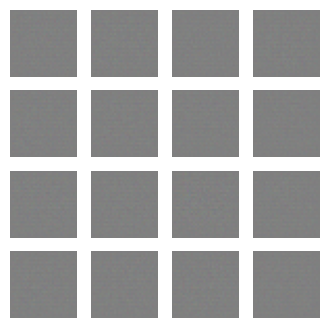

In [12]:
# generate a batch of noise input (batch size = 16)
test_noise = tf.random.normal([16, noise_input])

# feed the batch to the untrained generator
test_image = generator(test_noise)

# visualize sample output
plot_results(test_image, n_cols=4)

print(f'shape of the generated batch: {test_image.shape}')

## The Discriminator Model to use in the GAN
As input, it will receive a 32 x 32 x 3 image and as output it will have a binary value.

I'm using Convolutional layers and a stride of 2, so the input data size is halved.

Some of the recommendations made by Soumith Chintala are used, such as the use of LeakyRelu activators, or the use of Dropout layers.

The data is flattened with the Flatten layer before passing to the last dense layer. Because we are only interested in the values 0 and 1, we use a sigmoid trigger for the final Dense layer. It is used to identify the image as false or authentic.

In [13]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[32, 32, 3]),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])

In [14]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 dropout_2 (Dropout)         (None, 4, 4, 64)          0         
                                                                 
 flatten (Flatten)           (None, 1024)             

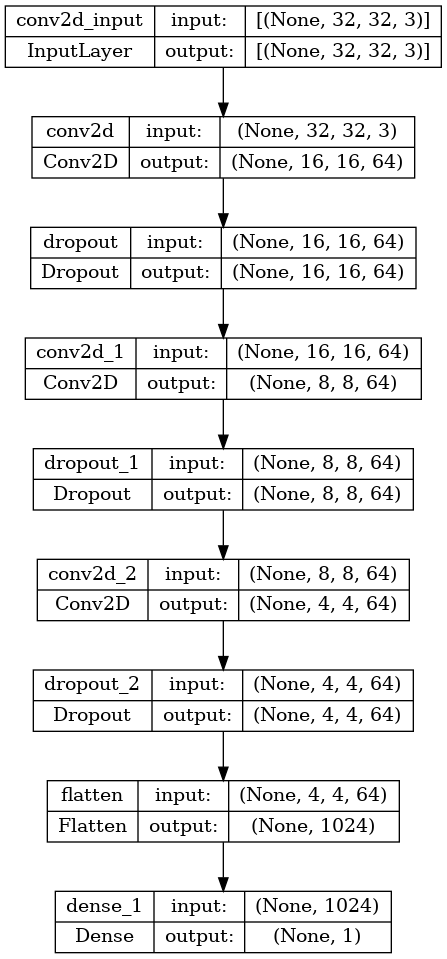

In [15]:
plot_model(discriminator, show_shapes=True, show_layer_names=True)

In [16]:
#Creating the GAN with the Generator & Discriminator models. 
gan = keras.models.Sequential([generator, discriminator])
gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 3)         739075    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 79745     
                                                                 
Total params: 818,820
Trainable params: 818,052
Non-trainable params: 768
_________________________________________________________________


In [17]:
 #discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
optimizer_disc = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizer_gan = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer_disc, metrics=['accuracy'])

discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer=optimizer_gan)

In [18]:
#functions to smooth the labels. Positive, and negative.
def smooth_positive(y):
  #range values 0.8 - 1.2
  return y -0.2 + (np.random.random(y.shape) * 0.4)

def smooth_negative(y):
  #range values 0 - 0.3
  return y + np.random.random(y.shape) * 0.3

In [19]:
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=30):
    """ Defines the two-phase training loop of the GAN
    Args:
      gan -- the GAN model which has the generator and discriminator
      dataset -- the training set of real images
      random_normal_dimensions -- dimensionality of the input to the generator
      n_epochs -- number of epochs
    """
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))       
        for real_images in dataset:
            # infer batch size from the training batch
            batch_size = real_images.shape[0]

            # Train the discriminator - PHASE 1
            # create the noise
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])

            # use the noise to generate fake images
            fake_images = generator(noise)

            # create a list by concatenating the fake images with the real ones
            mixed_images = tf.concat([fake_images, real_images], axis=0)

            # Create the labels for the discriminator
            # 0 for the fake images
            # 1 for the real images
            discriminator_zeros = smooth_negative(np.zeros((batch_size, 1)))
            discriminator_ones = smooth_positive(np.ones((batch_size, 1)))
            discriminator_labels= tf.convert_to_tensor(np.concatenate((discriminator_zeros, discriminator_ones)))
            #discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

            # ensure that the discriminator is trainable
            discriminator.trainable = True

            # use train_on_batch to train the discriminator with the mixed images and the discriminator labels
            discriminator.train_on_batch(mixed_images, discriminator_labels)

            # Train the generator - PHASE 2
            # create a batch of noise input to feed to the GAN
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
            
            # label all generated images to be "real"
            generator_ones = smooth_positive(np.ones((batch_size, 1)))
            generator_labels = tf.convert_to_tensor(generator_ones)
            #generator_labels = tf.constant([[1.]] * batch_size)

            # freeze the discriminator
            discriminator.trainable = False

            # train the GAN on the noise with the labels all set to be true
            gan.train_on_batch(noise, generator_labels)
        
        # plot the fake images used to train the discriminator
        plot_results(fake_images[0:30], 10)                     
        plt.show()      

In [20]:
#Sample of smoothed labels
#[0:4] False
#[4:9] True
batch_size=5

#discriminator_zeros = np.zeros((batch_size, 1)) #+ np.ones(batch_size)
discriminator_zeros = smooth_negative(np.zeros((batch_size, 1)))
discriminator_ones = smooth_positive(np.ones((batch_size, 1)))
discriminator_labels= tf.convert_to_tensor(np.concatenate((discriminator_zeros, discriminator_ones)))
discriminator_labels

<tf.Tensor: shape=(10, 1), dtype=float64, numpy=
array([[0.00205874],
       [0.12044442],
       [0.12780903],
       [0.01573749],
       [0.21276974],
       [1.021767  ],
       [1.16317652],
       [1.14860035],
       [0.8137134 ],
       [1.01035827]])>

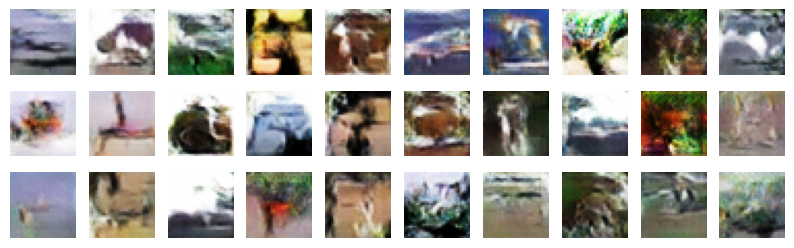

In [21]:
train_gan(gan, dataset, noise_input, 40)

In [22]:
# Configurables Generator & Discriminator

In [23]:
tf.keras.backend.clear_session()

In [24]:
def adapt_generator(initial_0, initial_1, nodes, upsamplings, multnodes = 1.0, endnodes = 3, input_noise=100):
  #initial_0, initial_1: size of the initial mini image. 
  #nodes: nodes in the first Dense layers. 
  #upsamplings: number og upsamplings bucles. 
  #multnodes: a multiplicator to modify the nodes in each upsampling bucle. 
  #endnodes: nodes of the last layer. 
  #input_noise: size of the noise. 

  model = keras.models.Sequential()

  #First Dense layer. 
  model.add(keras.layers.Dense(initial_0 * initial_1 * nodes, input_dim=input_noise, 
                               activation=keras.layers.LeakyReLU(alpha=0.2)))
  model.add(keras.layers.Reshape([initial_0, initial_1, nodes]))
  model.add(keras.layers.BatchNormalization())

  #Upsampling bucles. 
  nodeslayers = nodes
  for i in range(upsamplings-1):
    nodeslayers = nodeslayers * multnodes
    model.add(keras.layers.Conv2DTranspose(nodeslayers , kernel_size=4, strides=2, padding="SAME", 
                                 activation=keras.layers.LeakyReLU(alpha=0.2)))
    model.add(keras.layers.BatchNormalization())

  #last upsample and last layer. 
  model.add(keras.layers.Conv2DTranspose(endnodes, kernel_size=4, strides=2, padding="SAME", 
                                 activation='tanh'))
  
  return model

In [25]:
def adapt_discriminator(nodes, downsamples, multnodes = 1.0, in_shape=[32, 32, 3]):
  #nodes: nodes in the first Dense layers.
  #downsamples: number of downsamples bucles. 
  #multnodes: a multiplicator to modify the nodes in each downsample bucle.
  #in_shape: Shape of the input image. 

  model = keras.models.Sequential()
  
  #input layer % first downsample 
  model.add(keras.layers.Conv2D(nodes, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=in_shape))
  model.add(keras.layers.Dropout(0.4))
  
  #creating downsamples
  nodeslayers = nodes
  for i in range(downsamples - 1):
    nodeslayers = nodeslayers * multnodes
    model.add(keras.layers.Conv2D(nodeslayers, kernel_size=3, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)))
    model.add(keras.layers.Dropout(0.4))
  
  #ending model
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(1, activation="sigmoid"))
  
  return model

In [26]:
adapt_gene = adapt_generator(4, 4, 128, 3, multnodes = 0.5)
adapt_disc = adapt_discriminator(64, 3, multnodes = 2)

In [27]:
adapt_gene.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              206848    
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 128)        512       
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 64)         131136    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                                 
                                                        

In [28]:
adapt_disc.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 dropout_2 (Dropout)         (None, 4, 4, 256)         0         
                                                                 
 flatten (Flatten)           (None, 4096)             

In [29]:
adapt_gana2 = keras.models.Sequential([adapt_gene, adapt_disc])

In [30]:
optimizer_disc = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizer_gan = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
adapt_disc.compile(loss='binary_crossentropy', optimizer=optimizer_disc, metrics=['accuracy'])

adapt_disc.trainable = False
adapt_gana2.compile(loss="binary_crossentropy", optimizer=optimizer_gan)

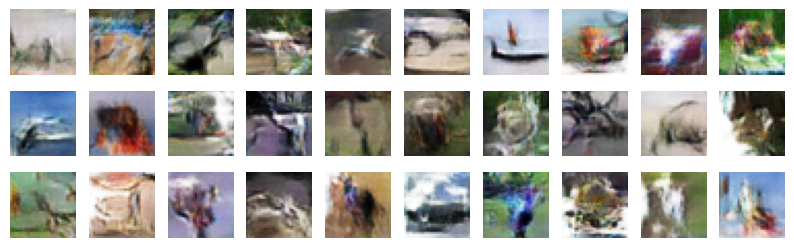

In [31]:
train_gan(adapt_gana2, dataset, noise_input, 40)

In [32]:
tf.keras.backend.clear_session()

# Conclusions Fork & Improve
## If you liked the notebook, please consider **upvoting it**. I will be very happy, and it encourages me to continue publishing.

It seems to me that the result with the second models has been better than with the first. Therefore, the use of node reduction in the generator and the increase in the discriminator have provided good results. The most important improvement is seen with the images generated with 30 epochs.

With 100 epochs of training, figures begin to appear in the content of the images. In three of them a vehicle could be guessed, and some of the figures could be confused with animals.

I think we've done a good job.

We have used a new dataset that asked us to perform a different number of Upsamples than the one performed in the previous article. So, I hope that it has become much clearer for us how the main structure of a GAN is built.

Taking advantage of the fact that we already have it clear, we have encapsulated it in a couple of functions. That allows us to create different GAN models that adapt to different datasets, changing only the parameters of the functions.

We have also used a new GAN Hack: the smoothing of the labels of the images used.

We have two new functions that allow us to create Generators and Discriminators, and they could be used to create a model that works with the MNIST Dataset. It can be a good exercise to practice by yourself with simple DCGANs.

This notebook is part of a GAN Tutorial. You have the full list or articles and references to other notebooks in medium: 
https://medium.com/@peremartra/list/gans-from-zero-to-hero-d8e6cb773f93

## Continue with the next notebook in the GANs series: 
Accelerate your GAN's using TPUs: 
https://www.kaggle.com/code/peremartramanonellas/gan-tutorial-3-how-to-use-tpus-to-train-a-gan
